# BTC Hourly Close — Task 1 (Distribution) & Task 2 (Dry/Wet Years)

**Author:** Nadhir Benhalima

This notebook reproduces the project’s Task 1 and Task 2 analyses directly in Python.

- Dataset: `data/btc_hourly_ohclv_ta.csv`
- Time column: `DATETIME`
- Variable of interest: `Q = CLOSE`


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

sns.set_context("notebook")

# --- Data path (prefer data/, fallback to root)
DATA_CANDIDATES = [
    "data/btc_hourly_ohclv_ta.csv",
    "btc_hourly_ohclv_ta.csv",
]

def find_data_path(candidates=DATA_CANDIDATES):
    for p in candidates:
        try:
            with open(p, "rb"):
                return p
        except FileNotFoundError:
            continue
    raise FileNotFoundError(
        "Could not find BTC CSV. Tried: " + ", ".join(candidates)
    )

data_path = find_data_path()
print("Using:", data_path)

# Load
df = pd.read_csv(data_path)

# Parse datetime and define Q
df["DATETIME"] = pd.to_datetime(df["DATETIME"], errors="coerce")
df = df.dropna(subset=["DATETIME"]).sort_values("DATETIME")

df["Q"] = pd.to_numeric(df["CLOSE"], errors="coerce")
df = df.dropna(subset=["Q"])

print("Rows:", len(df), "Cols:", df.shape[1])
print("Datetime range:", df["DATETIME"].min(), "->", df["DATETIME"].max())
print(df[["DATETIME", "Q"]].head())


Using: data/btc_hourly_ohclv_ta.csv
Rows: 95925 Cols: 29
Datetime range: 2014-12-15 06:00:00 -> 2025-11-23 00:00:00
             DATETIME       Q
0 2014-12-15 06:00:00  349.54
1 2014-12-15 07:00:00  345.20
2 2014-12-15 08:00:00  345.81
3 2014-12-15 09:00:00  347.97
4 2014-12-15 10:00:00  346.98


In [3]:
def ecdf(x: np.ndarray):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    x_sorted = np.sort(x)
    y = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    return x_sorted, y


def aic(ll: float, k: int) -> float:
    return 2 * k - 2 * ll


def bic(ll: float, k: int, n: int) -> float:
    return k * np.log(n) - 2 * ll


def summarize_series(x: pd.Series) -> pd.DataFrame:
    x = pd.to_numeric(x, errors="coerce").dropna().to_numpy()
    p = np.percentile(x, [1, 5, 25, 75, 95, 99])
    return pd.DataFrame(
        {
            "n": [len(x)],
            "min": [np.min(x)],
            "max": [np.max(x)],
            "mean": [np.mean(x)],
            "median": [np.median(x)],
            "sd": [np.std(x, ddof=1)],
            "skew": [stats.skew(x, bias=False)],
            "excess_kurtosis": [stats.kurtosis(x, fisher=True, bias=False)],
            "p01": [p[0]],
            "p05": [p[1]],
            "p25": [p[2]],
            "p75": [p[3]],
            "p95": [p[4]],
            "p99": [p[5]],
        }
    )


def fit_and_score_distribution(data: np.ndarray, dist_name: str):
    """Fit a scipy.stats distribution and compute LL/AIC/BIC and KS p-value.

    Notes:
    - KS p-values are approximate here because parameters are estimated on the same data.
    - For lognorm/gamma we constrain loc=0 (common convention).
    """
    data = np.asarray(data)
    data = data[np.isfinite(data)]

    if dist_name == "norm":
        dist = stats.norm
        params = dist.fit(data)
        k = 2
    elif dist_name == "lognorm":
        dist = stats.lognorm
        params = dist.fit(data, floc=0)
        k = 2
    elif dist_name == "gamma":
        dist = stats.gamma
        params = dist.fit(data, floc=0)
        k = 2
    else:
        raise ValueError(f"Unsupported distribution: {dist_name}")

    ll = float(np.sum(dist.logpdf(data, *params)))
    n = int(len(data))

    try:
        ks_stat, ks_p = stats.kstest(data, dist.cdf, args=params)
        ks_p = float(ks_p)
    except Exception:
        ks_p = np.nan

    return {
        "distribution": dist_name,
        "params": params,
        "loglik": ll,
        "k": k,
        "n": n,
        "AIC": aic(ll, k),
        "BIC": bic(ll, k, n),
        "KS_p": ks_p,
    }


def plot_hist_with_pdfs(ax, data, fits, bins=120):
    ax.hist(data, bins=bins, density=True, alpha=0.35, color="C0")
    xs = np.linspace(np.min(data), np.max(data), 800)
    for i, fit in enumerate(fits):
        dist = getattr(stats, fit["distribution"])
        ax.plot(xs, dist.pdf(xs, *fit["params"]), lw=2, label=fit["distribution"], color=f"C{i+1}")
    ax.set_title("Histogram + fitted PDFs")
    ax.set_xlabel("Q (CLOSE)")
    ax.set_ylabel("Density")
    ax.legend()


def plot_ecdf_with_cdfs(ax, data, fits):
    xs, ys = ecdf(data)
    ax.plot(xs, ys, color="black", lw=2, label="ECDF")
    for i, fit in enumerate(fits):
        dist = getattr(stats, fit["distribution"])
        ax.plot(xs, dist.cdf(xs, *fit["params"]), lw=2, label=f"{fit['distribution']} CDF", color=f"C{i+1}")
    ax.set_title("ECDF + fitted CDFs")
    ax.set_xlabel("Q (CLOSE)")
    ax.set_ylabel("F(Q)")
    ax.legend()


def qqplot_logQ_normal(ax, data):
    logQ = np.log(data)
    stats.probplot(logQ, dist="norm", plot=ax)
    ax.set_title("QQ plot: log(Q) vs Normal")


def plot_density_logx(ax, data):
    sns.kdeplot(data, ax=ax, color="C0", lw=2)
    ax.set_xscale("log")
    ax.set_title("Density with log10 x-scale")
    ax.set_xlabel("Q (log scale)")
    ax.set_ylabel("Density")


## Task 1 — Distribution (Q = CLOSE)

We compute descriptive stats, fit candidate distributions (Normal / Lognormal / Gamma), compare them with log-likelihood + AIC/BIC, and visualize fit quality.


In [3]:
Q = df["Q"].to_numpy()
Q = Q[np.isfinite(Q)]

# For positive-only distributions and logs
Q_pos = Q[Q > 0]

# --- Descriptive stats
stats_table = summarize_series(pd.Series(Q))
stats_table

,n,min,max,mean,median,sd,skew,excess_kurtosis,p01,p05,p25,p75,p95,p99
0,95925,165.07,126113.68,26829.919934,10968.3,31328.742208,1.36069,0.933245,226.39,255.026,3580.11,42041.78,102316.314,116769.426


In [4]:
# --- Fit and compare distributions
fits = []

# Normal on all Q
fits.append(fit_and_score_distribution(Q, "norm"))

# Lognormal and Gamma require strictly positive data
if len(Q_pos) < 10:
    raise ValueError("Not enough positive Q values for lognormal/gamma fits.")

fits.append(fit_and_score_distribution(Q_pos, "lognorm"))
fits.append(fit_and_score_distribution(Q_pos, "gamma"))

comparison = pd.DataFrame(
    [
        {
            "distribution": f["distribution"],
            "n_used": f["n"],
            "loglik": f["loglik"],
            "AIC": f["AIC"],
            "BIC": f["BIC"],
            "KS_p": f["KS_p"],
        }
        for f in fits
    ]
).sort_values(["AIC", "BIC"], ascending=True)

comparison

,distribution,n_used,loglik,AIC,BIC,KS_p
2,gamma,95925,-1.061292e+06,2.122588e+06,2.122607e+06,0.0
1,lognorm,95925,-1.069218e+06,2.138439e+06,2.138458e+06,0.0
0,norm,95925,-1.129155e+06,2.258313e+06,2.258332e+06,0.0


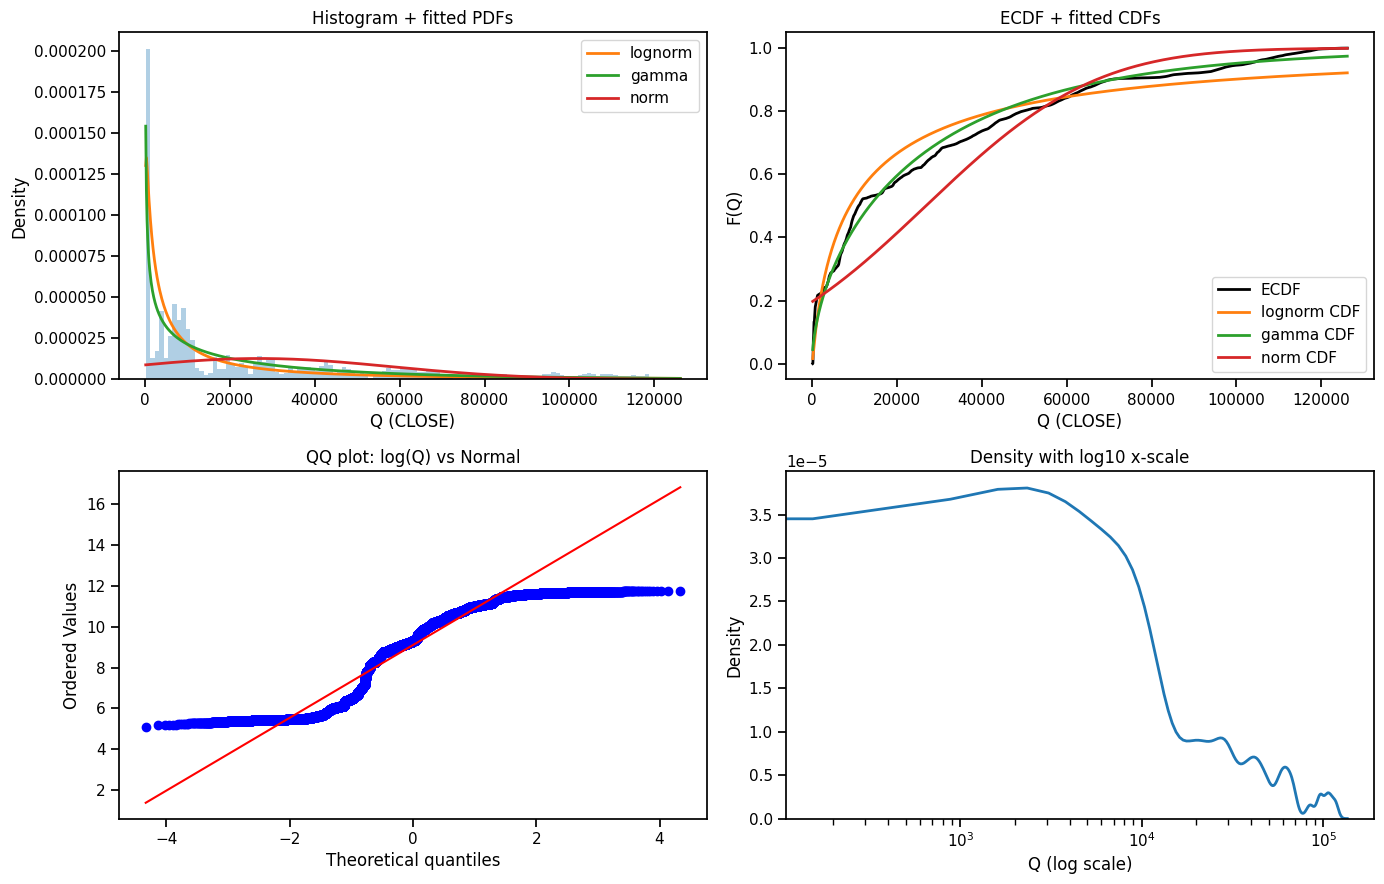

In [5]:
# --- Task 1 plots (4)
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# 1) Histogram + PDFs
plot_hist_with_pdfs(axes[0, 0], Q_pos, [f for f in fits if f["distribution"] in ("lognorm", "gamma")])
# Overlay normal (on full Q) separately so x-range aligns with positive axis
norm_fit = next(f for f in fits if f["distribution"] == "norm")
xs = np.linspace(np.min(Q_pos), np.max(Q_pos), 800)
axes[0, 0].plot(xs, stats.norm.pdf(xs, *norm_fit["params"]), lw=2, label="norm", color="C3")
axes[0, 0].legend()

# 2) ECDF + CDFs
plot_ecdf_with_cdfs(axes[0, 1], Q_pos, [f for f in fits if f["distribution"] in ("lognorm", "gamma")])
axes[0, 1].plot(xs, stats.norm.cdf(xs, *norm_fit["params"]), lw=2, label="norm CDF", color="C3")
axes[0, 1].legend()

# 3) QQ plot log(Q) vs Normal
qqplot_logQ_normal(axes[1, 0], Q_pos)

# 4) Density with log x-scale
plot_density_logx(axes[1, 1], Q_pos)

plt.tight_layout()
plt.show()

## Task 2 — Dry & Wet Years

We identify the 2 driest and 2 wettest years based on annual mean(Q), then compare intra-annual behavior (time series, cumulative, monthly distribution, monthly mean).

In [4]:
d = df[["DATETIME", "Q"]].copy()
d["YEAR"] = d["DATETIME"].dt.year
d["MONTH"] = d["DATETIME"].dt.month

annual = (
    d.groupby("YEAR", as_index=False)
    .agg(mean_Q=("Q", "mean"), n=("Q", "size"))
    .sort_values("mean_Q", ascending=True)
)

# 2 driest + 2 wettest
selected_dry = annual.head(2).assign(label="dry")
selected_wet = annual.tail(2).assign(label="wet")
selected = pd.concat([selected_dry, selected_wet], ignore_index=True).sort_values(["label", "mean_Q"])

selected_years = selected["YEAR"].tolist()
selected

,YEAR,mean_Q,n,label
0,2015,272.074508,8760,dry
1,2014,322.838582,402,dry
2,2024,65899.996954,8784,wet
3,2025,103155.715788,7851,wet


In [7]:
# --- Annual summary table (all years)
annual.head(10)

,YEAR,mean_Q,n
1,2015,272.074508,8760
0,2014,322.838582,402
2,2016,566.337690,8784
3,2017,3957.259584,8760
5,2019,7370.554533,8760
4,2018,7548.607966,8760
6,2020,11078.472442,8784
8,2022,28225.684604,8760
9,2023,28813.933736,8760
7,2021,47385.078959,8760


In [9]:
# --- Seasonal signature table for selected years
sel = d[d["YEAR"].isin(selected_years)].copy()

seasonal_signature = (
    sel.groupby(["YEAR", "MONTH"], as_index=False)
    .agg(
        mean_Q=("Q", "mean"),
        median_Q=("Q", "median"),
        q25=("Q", lambda x: np.percentile(x, 25)),
        q75=("Q", lambda x: np.percentile(x, 75)),
        n=("Q", "size"),
    )
)
seasonal_signature.head(12)

,YEAR,MONTH,mean_Q,median_Q,q25,q75,n
0,2014,12,322.838582,320.915,315.1025,330.4725,402
1,2015,1,250.487970,247.470,219.2625,277.0050,744
2,2015,2,233.703631,235.715,224.1725,241.0550,672
3,2015,3,268.523387,269.210,252.5900,283.3175,744
4,2015,4,234.645000,233.800,224.4800,244.3775,720
5,2015,5,237.326358,237.070,235.3150,239.8100,744
6,2015,6,237.475819,237.165,228.4800,245.1800,720
7,2015,7,278.540054,277.850,269.7100,288.6000,744
8,2015,8,251.991841,258.400,229.5300,269.0375,744
9,2015,9,233.489181,232.700,229.9000,237.2625,720


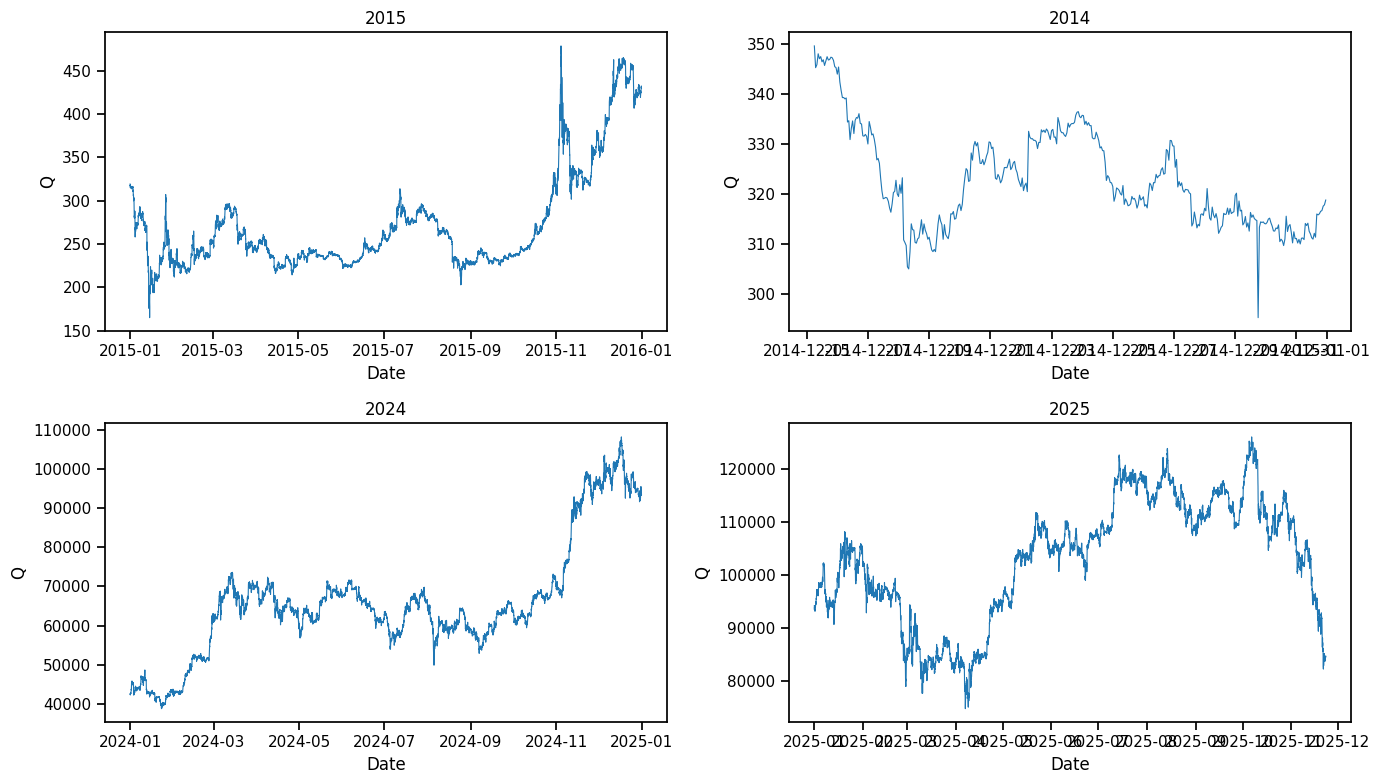

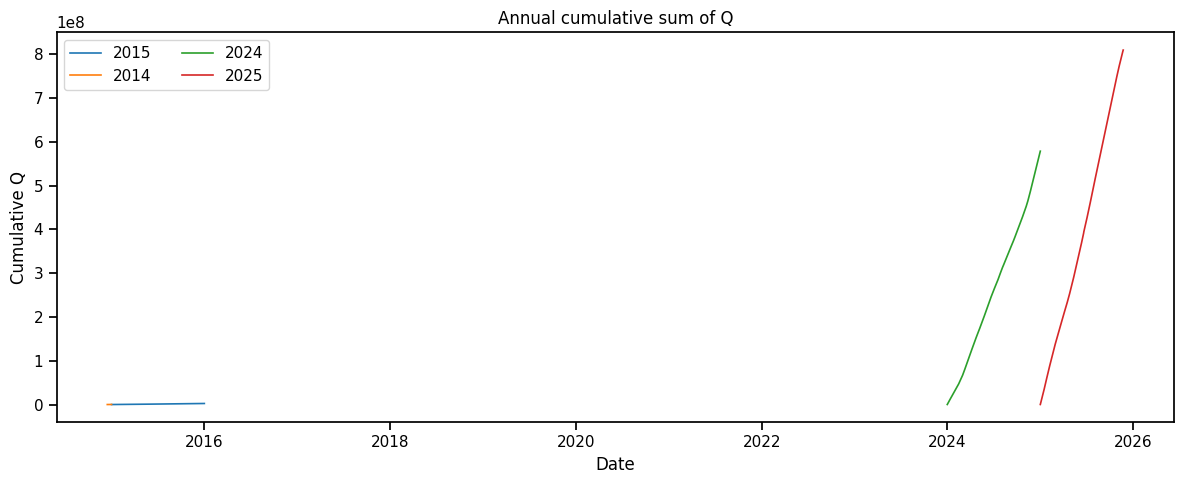

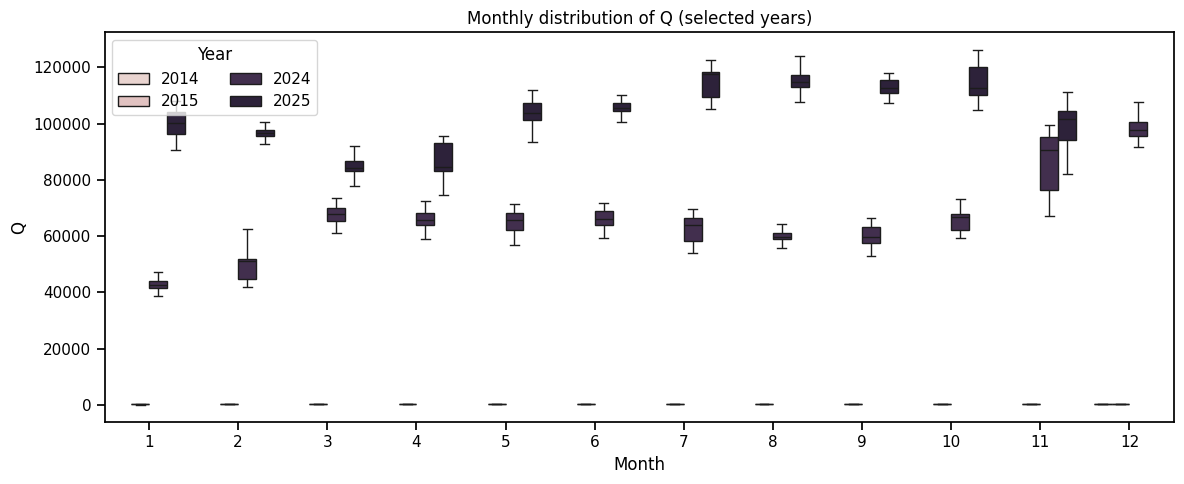

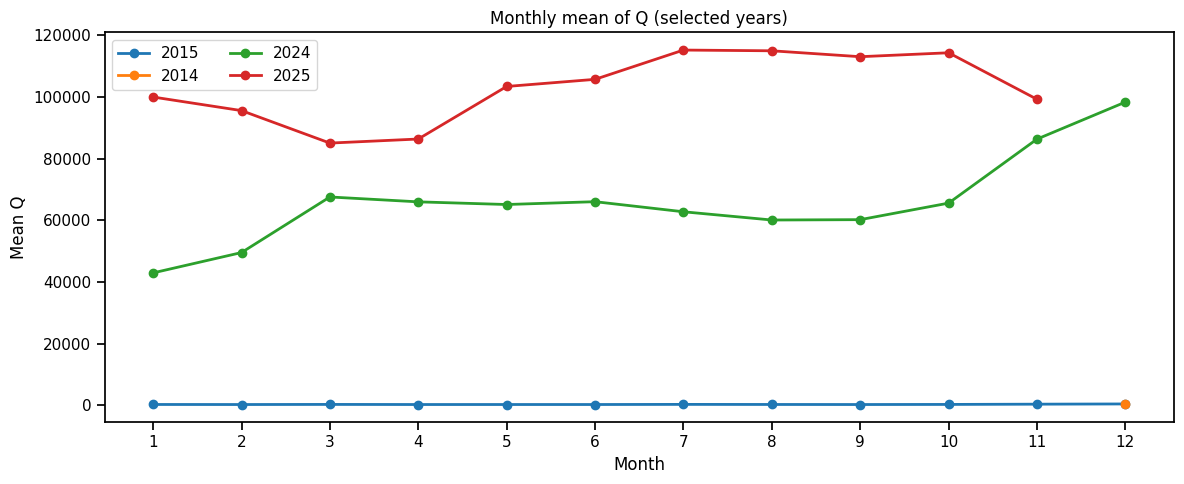

In [6]:
# --- Task 2 plots (4)

# 1) Time series of Q for selected years (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=False)
axes = axes.flatten()

for ax, year in zip(axes, selected_years):
    sub = sel[sel["YEAR"] == year].sort_values("DATETIME")
    ax.plot(sub["DATETIME"], sub["Q"], lw=0.8)
    ax.set_title(str(year))
    ax.set_xlabel("Date")
    ax.set_ylabel("Q")

plt.tight_layout()
plt.show()

# 2) Annual cumulative sum within each selected year
fig, ax = plt.subplots(figsize=(12, 5))
for year in selected_years:
    sub = sel[sel["YEAR"] == year].sort_values("DATETIME")
    x = sub["DATETIME"]
    y = sub["Q"].cumsum().to_numpy()
    ax.plot(x, y, lw=1.2, label=str(year))
ax.set_title("Annual cumulative sum of Q")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Q")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

# 3) Monthly boxplots of Q for selected years
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(
    data=sel,
    x="MONTH",
    y="Q",
    hue="YEAR",
    ax=ax,
    showfliers=False,
)
ax.set_title("Monthly distribution of Q (selected years)")
ax.set_xlabel("Month")
ax.set_ylabel("Q")
ax.legend(title="Year", ncol=2)
plt.tight_layout()
plt.show()

# 4) Monthly mean lines for selected years
monthly_means = sel.groupby(["YEAR", "MONTH"], as_index=False).agg(mean_Q=("Q", "mean"))
fig, ax = plt.subplots(figsize=(12, 5))
for year in selected_years:
    sub = monthly_means[monthly_means["YEAR"] == year].sort_values("MONTH")
    ax.plot(sub["MONTH"], sub["mean_Q"], marker="o", lw=2, label=str(year))
ax.set_xticks(range(1, 13))
ax.set_title("Monthly mean of Q (selected years)")
ax.set_xlabel("Month")
ax.set_ylabel("Mean Q")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

## Optional — Save figures to `outputs/`

If you want to keep PNGs alongside the existing R pipeline outputs, run the next cell.

In [7]:
from pathlib import Path

out_dir = Path("outputs")
out_dir.mkdir(exist_ok=True)

print("Saving is optional; example filenames:")
print(out_dir / "py_task1_plots.png")
print(out_dir / "py_task2_plots.png")

# Tip: if you want exact exports, wrap each plot section in its own figure
# and call plt.savefig(..., dpi=150, bbox_inches='tight') before plt.show().


Saving is optional; example filenames:
outputs\py_task1_plots.png
outputs\py_task2_plots.png
